# Data 620 -Project 2

**Tyler Baker and Rathish Parayil Sasidharan**

Identify a large 2-node network dataset—you can start with a dataset in a repository.  

Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

What can you infer about each of the distinct groups?

**Project Overview**

As part of this project , we will be analysing the movies review by the users. We are building a 2 mode network of users and movies and the weighted edge between user and movie represent the rating given by users

The data is available on the below site
http://konect.cc/networks/librec-filmtrust-ratings/

The dataset has a total 3579 nodes with a total 1,508 Users and 2,071 movies.
There is a total 35,494 reviews.
The movie ratings are on a scale of 0 -4.

**Link to project Presentation:**

https://www.youtube.com/watch?v=Kd0Byn9HKpc

**Data Preparation**

Load the necessary Python packages and read the movies and user reviews.


In [198]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite
import community
from community import community_louvain
import seaborn as sns
import numpy as np

**Read the data file into panda data frame**


In [236]:
#read the file
#userMovierating = pd.read_csv("D:\Personal\Masters\Rathish-Personal\CUNY\Summer-22\Rathish\Filmrating\librec-filmtrust-ratings\out.librec-filmtrust-ratings", header=None, delimiter=r"\s+")
userMovierating = pd.read_csv("https://raw.githubusercontent.com/rathish-ps/Data620/main/out.librec-filmtrust-ratings", header=None, delimiter=r"\s+")

#remove the first line
userMovierating = userMovierating.iloc[1:]
#Add column headers
userMovierating.columns =['UserId', 'MovieId','Weight']

In [237]:
userMovierating.head(10)

,UserId,MovieId,Weight
1,1,1,2
2,1,10,4
3,1,11,4
4,1,12,4
5,1,2,4
6,1,3,3.5
7,1,4,3
8,1,5,4
9,1,6,3.5
10,1,7,3.5


As we could see that both userId and movieIds are numbers, we need to add an identifier to differenentiate between them to create a bipartite network

**Created a Bipartite Graph of Users and Movies**

In [162]:
movieG = nx.Graph()
for r, d in userMovierating.iterrows():
    personId = 'P{0}'.format(d['UserId'])  
    movieId = 'C{0}'.format(d['MovieId'])
    movieG.add_node(personId, bipartite = 0)
    movieG.add_node(movieId, bipartite = 1)
    movieG.add_edge(personId, movieId, weight=d['Weight'])

In [171]:
print(nx.info(movieG))

Name: 
Type: Graph
Number of nodes: 3579
Number of edges: 35494
Average degree:  19.8346


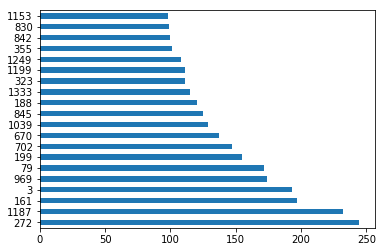

In [168]:
userMovierating['UserId'].value_counts().head(20).plot(kind='barh')

We could see that persons  (272,1187,161 etc...) has been agressively rating movies and hence they have higher degrees.

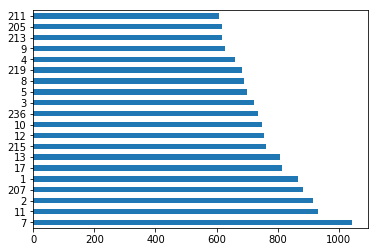

In [170]:
userMovierating['MovieId'].value_counts().head(20).plot(kind='barh')

From the movie nodes degree histogram , we could see that the movies with ID 7,11,2,207 etc got the highest number of degrees meaning
these movies has been rated by many users.

Also we expect the top users and movies from the above 2 histogram will falls into the highest degree centranlity list.
we will review this later part of the project

Let's check some network characteristics:

In [172]:


print("Bipartite Network G\n  Bipartite: {}\n  Connected: {}".format(nx.is_bipartite(movieG), 
                                                                 nx.is_connected(movieG)))



Bipartite Network G
  Bipartite: True
  Connected: False


Since the network has some unconnected subgraphs, we will remove these and work on the largest connected subgraph. 

In [177]:
subgraphs = nx.connected_component_subgraphs(movieG)
for cc in subgraphs:
    print (len(cc))
Gsub = max(nx.connected_component_subgraphs(movieG), key=len)
print(nx.info(Gsub))
#Diameter of the graph.
print(Gsub.size())
#print('Network diameter =', nx.diameter(Gsub))



3574
2
3
Name: 
Type: Graph
Number of nodes: 3574
Number of edges: 35491
Average degree:  19.8607
35491


We could see that there was 3 connected graphs and the largest one has got 3574 nodes. So we will use the largest connected network for the remaining part of the project and ignore the remaining the 2 networks which together got only 5 nodes.

**Two-mode Network Graph**

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Users and second set is a Movies. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no direct connection between Users or Movies. 

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


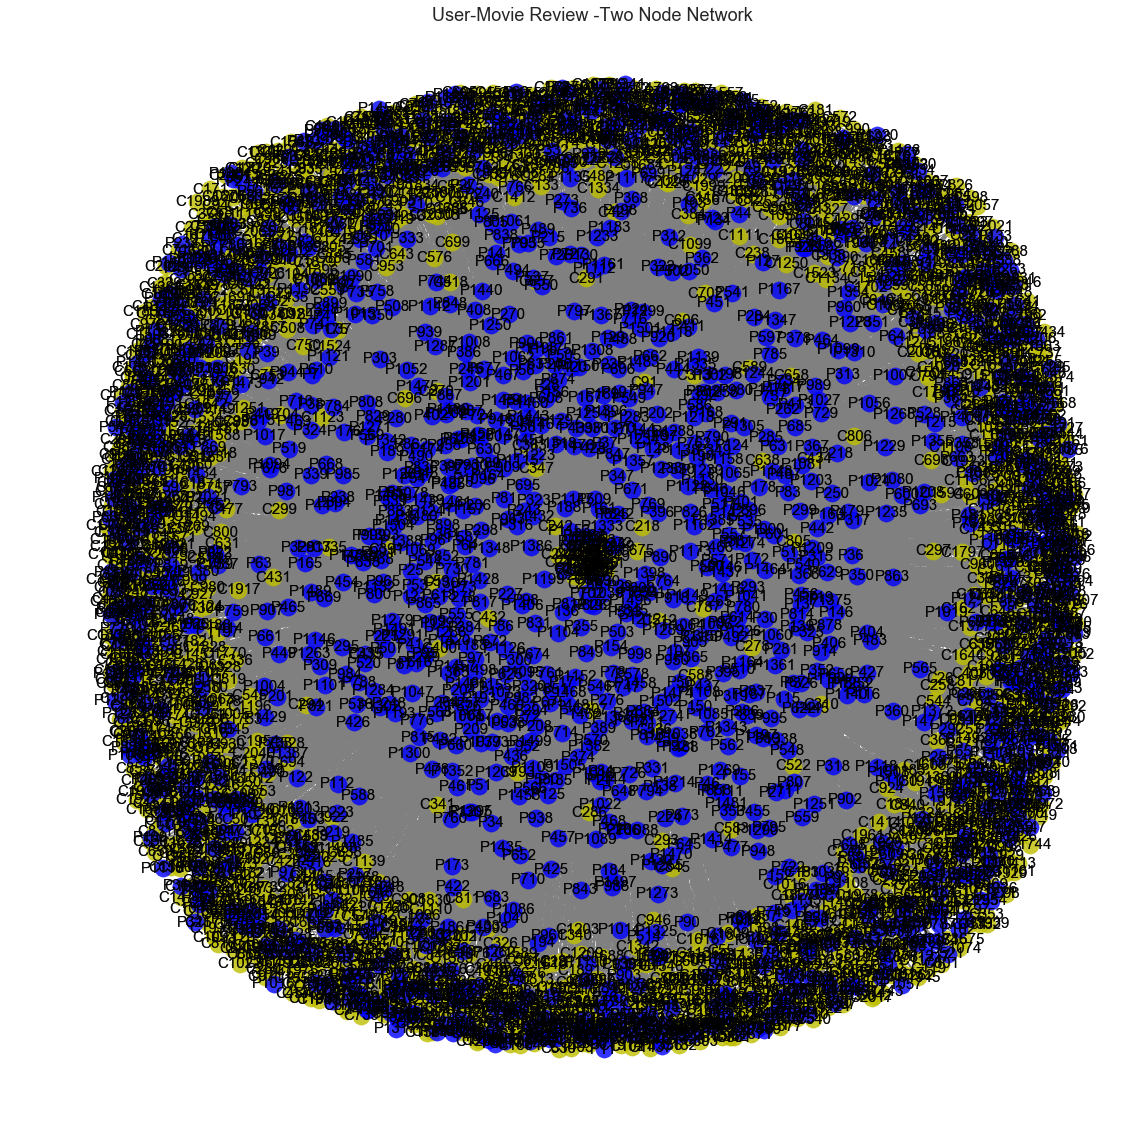

In [221]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))

moviesList, usersList = nx.bipartite.sets(Gsub)

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(Gsub, k=0.5, iterations=25)
nx.draw(Gsub, nodelist = moviesList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(Gsub, nodelist = usersList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('User-Movie Review -Two Node Network')
plt.show()



**Node centralities**

  Closeness - Closeness is the inverse sum of all shortest paths
  Betweenness - Number of shortest paths that pass through a node
  Degree - The number other nodes that a node is connected to


In [222]:
#Closeness Betweenness Degrees centrality
closeCntrl = nx.closeness_centrality(Gsub)
betweenCntrl = nx.betweenness_centrality(Gsub)
degreeCntrl = nx.degree_centrality(Gsub)

closeCntrldf1 = pd.DataFrame(list(closeCntrl.items()), columns=['Node', 'Closeness'])
betweenCntrldf2 = pd.DataFrame(list(betweenCntrl.items()), columns=['Node', 'Betweenness'])
degreeCntrldf3 = pd.DataFrame(list(degreeCntrl.items()), columns=['Node', 'Degrees'])
dfFinal = closeCntrldf1.join(betweenCntrldf2.set_index('Node'), on='Node').join(degreeCntrldf3.set_index('Node'), on='Node')

dfFinal.sort_values(['Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
dfFinal.head(20)

,Node,Closeness,Betweenness,Degrees
1875,C7,0.498674,0.087872,0.292191
2590,C207,0.471559,0.057434,0.246851
2311,C2,0.468590,0.063851,0.256087
804,C17,0.463004,0.049070,0.228100
864,C236,0.440730,0.037845,0.205430
3254,C1,0.438244,0.037569,0.242373
2943,C11,0.434936,0.047065,0.260565
3459,C12,0.432514,0.033880,0.211307
1860,C13,0.431261,0.042049,0.225861
112,C8,0.423091,0.024463,0.192835


In [216]:
centranalityTop20Df= dfFinal.head(20)

As we seen from the earlier histogram the movies 7 has the heighest closeness and good degree centrality since it was been reviewed by lot of users.

**Clustering**

In [58]:
movieCluster = bipartite.clustering(Gsub)
clusterDf = pd.DataFrame(list(movieCluster.items()), columns=['Node', 'Clustering'])
clusterDf.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
clusterDf.head(10)

,Node,Clustering
2680,P5,1.000000
2066,P230,1.000000
2534,C1254,0.567519
2532,C1250,0.567519
2529,C1247,0.567519
2525,C1243,0.567519
2523,C1241,0.567519
2520,C1238,0.567519
2518,C1235,0.567519
2533,C1252,0.567519


We could see that there is a cluster around the person P5 and all other clustors are around movies.

**Local clustering coefficient for two-mode networks** 

We could use Robins Alexander clustering method for Bipartite graph
Clustering values obtained using Robins Alexander method and Global Average Method differ because Robins Alexander method clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. 

Whereas Global Average Method uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.


In [59]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(Gsub), 3))

#Average clustering
print(round(bipartite.average_clustering(Gsub), 3))

0.613
0.213


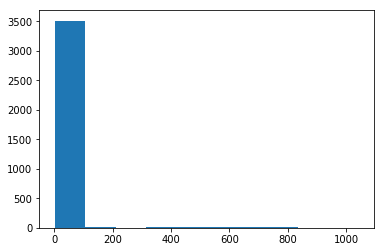

In [66]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()
    
plot_degree_dist(Gsub)  

**Cliques**

A clique is defined as a maximal complete subgraph of a given graph. 
For each node n, a maximal clique for n is a largest complete subgraph containing n.


In [228]:

cliques = nx.number_of_cliques(Gsub)
cliquesDf = pd.DataFrame(list(cliques.items()), columns=['Node', 'Cliques'])
cliquesDf.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
cliquesDf.head(10)


,Node,Cliques
1875,C7,1044
2943,C11,931
2311,C2,915
2590,C207,882
3254,C1,866
804,C17,815
1860,C13,807
1924,C215,761
3459,C12,755
1125,C10,750


**Density**

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense.


In [230]:
#Create Bipartite Node Sets for Users and Movies
moviesSet, usersSet = nx.bipartite.sets(Gsub)
len(usersSet), len(moviesSet)

# let's check the density of the user nodes
nx.bipartite.density(Gsub, usersSet)

#Density
#moviesSet, usersSet
print(bipartite.density(Gsub,moviesSet))
print(bipartite.density(Gsub,usersSet))


0.01139780560689437
0.01139780560689437


**Create the weighted projected graph of User and Movies.**

In [223]:
#Create Bipartite Node Sets for Users and Movies
moviesSet, usersSet = nx.bipartite.sets(Gsub)
len(usersSet), len(moviesSet)

(1505, 2069)

In [187]:
# let's check the density of the user nodes
nx.bipartite.density(Gsub, usersSet)


0.01139780560689437

It's interesting to note here that the user network is not particularly dense. 

Let's look at the resulting weighted projected graph of users.

In [188]:
UserPrjG = nx.bipartite.weighted_projected_graph(Gsub, usersSet, ratio=False)

MoviePrjG = nx.bipartite.weighted_projected_graph(Gsub, moviesSet, ratio=False)



In [189]:
#Let's look at the resulting weighted projected graph of users.
print(nx.info(UserPrjG))
triadic_closure = nx.transitivity(UserPrjG)
print("Triadic closure:", triadic_closure)



Name: 
Type: Graph
Number of nodes: 1505
Number of edges: 931602
Average degree: 1238.0093
Triadic closure: 0.9294632152125561


We could see that projected user graph has good transitivity meaning the reviewers are well connected.

**Communities Within the User Nodes**

To understand what the weighted projected user network looks like, let's examine the communities within the network. Communities are identified using the Louvain detection method. Generally, commmunities are nodes within the network that are more densely connected to each other than other nodes, or the concept of modularity.

In [191]:
partitions = community_louvain.best_partition(UserPrjG)
set(partitions.values())

{0, 1, 2}

In [193]:
len(partitions)

1505

There are only 3 communities within the user network.Let's plot the communities. 


C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


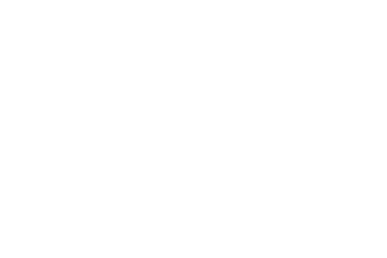

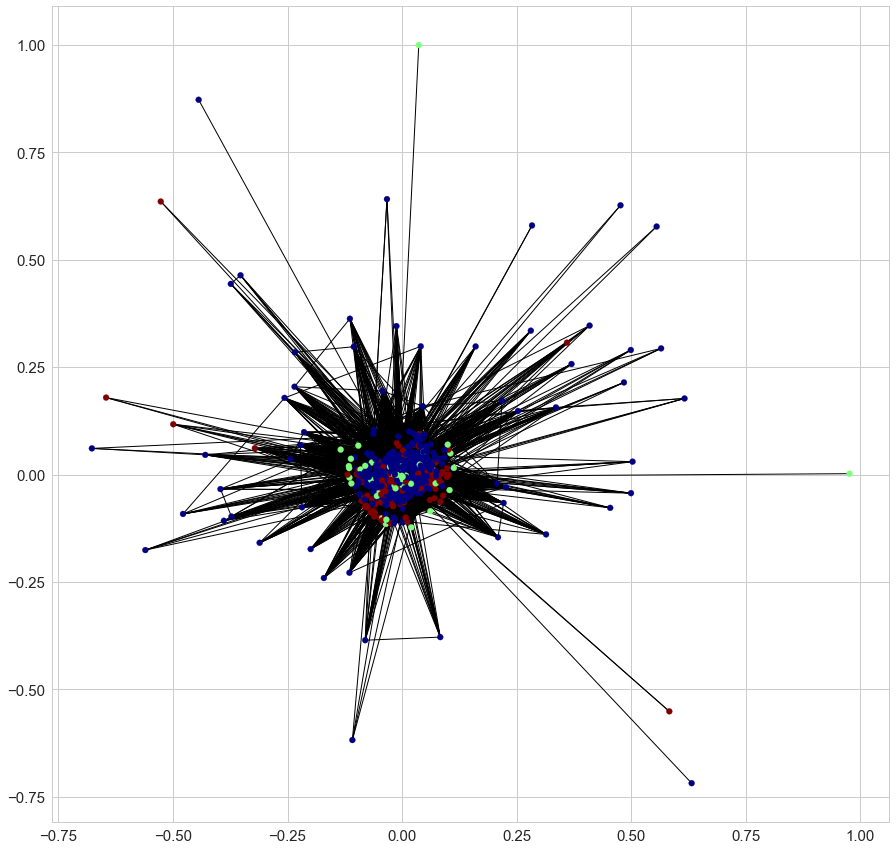

In [229]:
values = [partitions.get(node) for node in UserPrjG.nodes()]
spring_pos = nx.spring_layout(UserPrjG)
plt.axis("off")
#plt.figure(3,figsize=(12,12)) 
plt.figure(figsize=(15, 15))
#plt.rcParams['figure.figsize'] = (25, 15)
nx.draw_networkx(UserPrjG, pos = spring_pos, 
                 cmap = plt.get_cmap("jet"), node_color = values, 
                 node_size = 35, with_labels = False)

**Distribution of Users Within Communities**

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


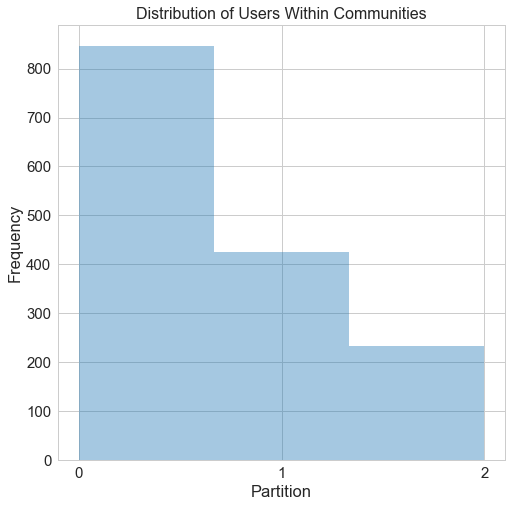

In [199]:
partitions_df = pd.DataFrame({'partition':partitions})
# function to generate histogram

def plot_dist(df, range, bins):

    # Plot the distribution of users within each community
    sns.set_style("whitegrid")    # Set style for seaborn output
    sns.set_context("notebook", font_scale=1.5)
    plt.figure(figsize=(8,8))
    plt.xticks(range)
    plt.xlabel("Partition")
    plt.ylabel("Frequency")
    plt.title("Distribution of Users Within Communities", fontsize=16)

    sns.distplot(partitions_df, bins=bins, kde=False, rug=False);
    


plot_dist(partitions_df, np.arange(0,3,1), 3);
    


**Trim the User Network Using the Island Method**

First we will trim the network based on the degree, nodes with less degree are either the movie with few people rated or the person who has rated only few movies.

In [69]:
def trim_degrees(g, degree=1):
    g2 = g.copy()
    d = nx.degree(g2)
    for n in g.nodes():
        
        if d[n] <= degree:
            g2.remove_node(n)
    return g2
movieRatingcore1=trim_degrees(G)
len(movieRatingcore1)

1686

In [231]:
movieRatingcore2=trim_degrees(Gsub,100)
len(movieRatingcore2)

44

In [232]:
nx.is_connected(movieRatingcore2)

False

In [207]:
Gsub1 = max(nx.connected_component_subgraphs(movieRatingcore2), key=len)

print(nx.info(Gsub1))

Name: 
Type: Graph
Number of nodes: 36
Number of edges: 57
Average degree:   3.1667


After trimming the nodes with less degree we again trim the netwrok based the movie ratings.

In [209]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if float(edata['weight']) >= float(weight):
                        g2.add_edge(f,to,weight=edata['weight'])
        return g2
        
def island_method(g, iterations=4):
    weights= [float(edata['weight']) for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    step=1
    z_bin = np.linspace(0,4,9)
    #for i in range(len(z_bin)):
    # print(z_bin[i])
    return [[z_bin[i], trim_edges(g, z_bin[i])] for i in range(len(z_bin))]
    #return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
   
islands=island_method(Gsub1)

In [210]:
print ('%-25s %-45s %-13s' % ('Rating more than', 'Nodes(Users + Review)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))



Rating more than          Nodes(Users + Review)                         Islands      
0.0                       36                                            [36]         
0.5                       36                                            [36]         
1.0                       36                                            [36]         
1.5                       36                                            [36]         
2.0                       35                                            [35]         
2.5                       32                                            [32]         
3.0                       28                                            [28]         
3.5                       19                                            [16, 3]      
4.0                       9                                             [7, 2]       


There is only 1 island with 36 node which has rating >= 0  <br>
There is only 1 island with 35 node which has rating >= 2  <br>
There is only 1 island with 32 node which has rating >= 2.5  <br>
There is only 1 island with 28 node which has rating >= 3 <br>
There is 2 islands with 16 and 3 nodes which has rating >= 3.5 <br>
There is 2 islands with 7 and 2 nodes which has maximum rating of 4

In [219]:
lss1 =list(nx.connected_component_subgraphs(islands[8][1]))
topNods = list(lss1[0].nodes()) + list(lss1[1].nodes())
print(topNods)

['P1187', 'C13', 'P161', 'C219', 'C3', 'C215', 'C207', 'C210', 'P272']


Let's plot the islands identified by the island method

C:\Users\rparayil\AppData\Local\activestate\0cb7efd1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


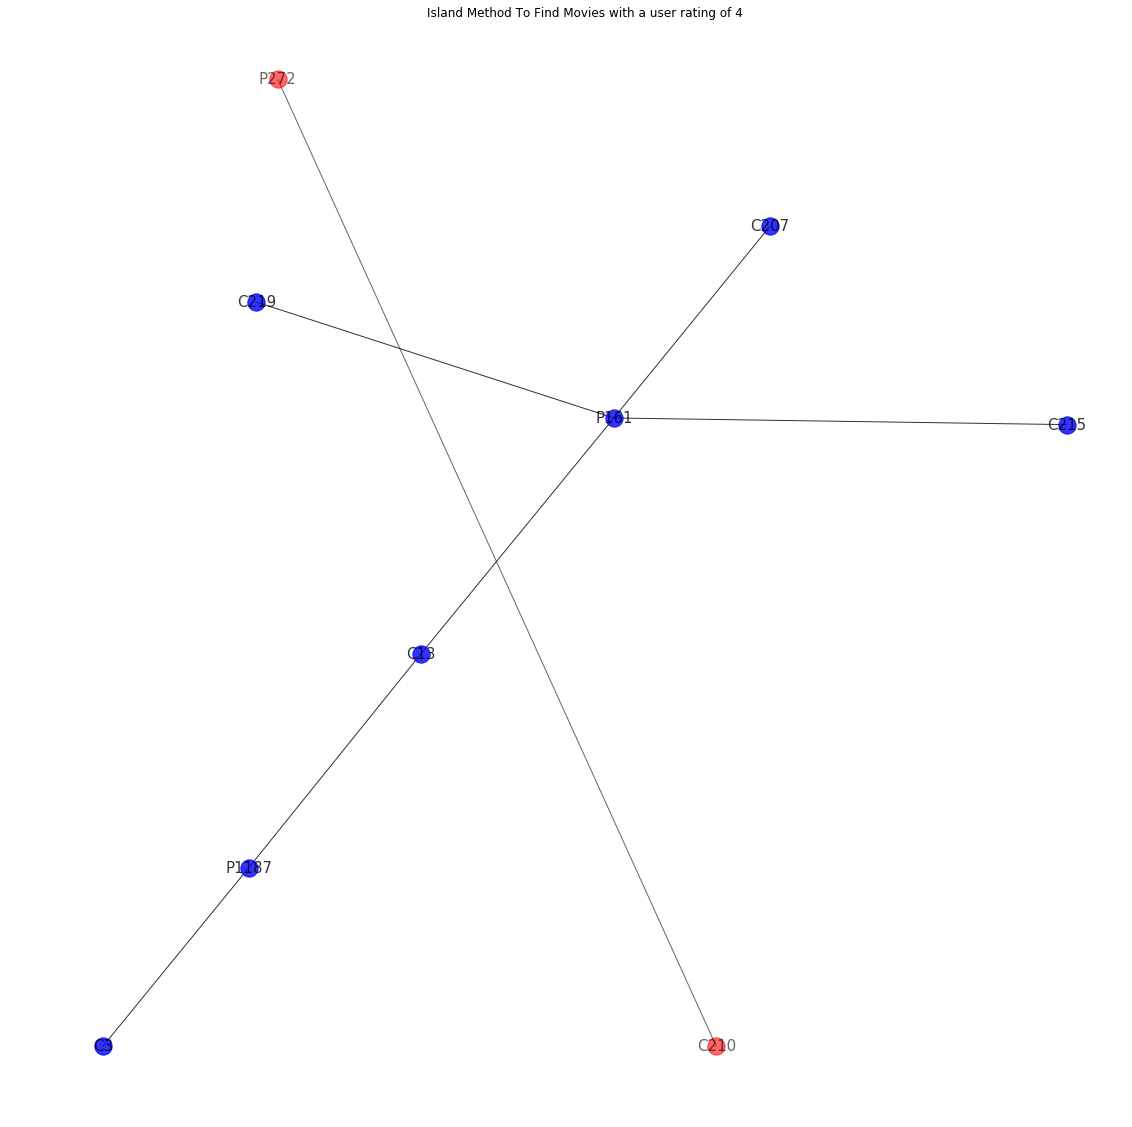

In [159]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 4.0:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('Island Method To Find Movies with a user rating of 4')
plt.show()

**Summary**

In [220]:
centranalityTop20Df.loc[centranalityTop20Df['Node'].isin(topNods)]

,Node,Closeness,Betweenness,Degrees
23,C207,0.470900,0.057274,0.246506
14,C13,0.430659,0.041932,0.225545
6,C3,0.418731,0.023532,0.202348
16,C215,0.417848,0.044377,0.212689
30,C219,0.406610,0.019015,0.190889
906,P1187,0.402392,0.052750,0.064841
2129,P272,0.399329,0.047471,0.068195
1882,P161,0.396754,0.025322,0.055059


From our analysis , we could see that top nodes measured based on centrality (degree and closeness centrality) falls into the islands identified by the island method.

Also we noticed that there are some active user communities exist within the user group who has actively reviewing most the movies.